# Experiment template. 
## Note: 
template for experiments

Sigmoid for segmentation
Segment

In [1]:
# description = {here could be a short description of the experiment}

# specific name of the experiment
eval_name = 'allInoc_nesterovmomentum_unet_softmax1'

if eval_name is None:
    with open(path_to_dir+'eval_name.txt') as data_file:    
        eval_name = json.load(data_file)
print "eval_name is", eval_name 

eval_name is allInoc_nesterovmomentum_unet_softmax1


## The task is to predict number of lesions in the photo
***
### Content:
* [Settings and experiment parameters](#sep)
* [Load Data](#ld)
* [Learning and visualizing results](#lav)
* [Conclusions](#c)
***

#### Togle ON/OFF the raw code

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
CODE WAS HIDDEN. TO TOGGLE ON/OFF THE RAW CODE, CLICK
<a href="javascript:code_toggle()">here</a>.''')

---
<a name="sep"/>
# Settings and experiment parameters
</a>

In [3]:
%env THEANO_FLAGS="device=gpu1"

### Check theano ####
import theano

env: THEANO_FLAGS="device=gpu1"


Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5005)


### Global variables and paths 
* $\textbf{Add the main directory '.../code' to   sys.path}$. 

The following directory was added:

In [4]:
#### Add the main dir to sys ####

import os, sys

parentdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
print parentdir

sys.path.insert(0, parentdir)

/slowhome/makarova/columbia/code


In [5]:
%load_ext autoreload
%autoreload 2

* $\textbf{Put your certain values or None}$ (then use run.ipynb to set them outside).

Note: In case you put None, files with parameters should be in the same directory with this .ipynb file 
(else change path_to_dir by what ever you want)


In [6]:
TRAIN_NN = True

N_FILTERS = 32
BATCH_SIZE = 20
N_EPOCHS = 10000
N_BATCHES_PER_EPOCH = 10
N_BATCHES_PER_EPOCH_valid = 10
PATCH_SIZE = 256

In [7]:
# Read global params from files
import json

print "N_FILTERS = ", N_FILTERS
print "BATCH_SIZE = ", BATCH_SIZE
print "N_EPOCHS = ", N_EPOCHS
print "PATCH SIZE = ", PATCH_SIZE

N_FILTERS =  32
BATCH_SIZE =  20
N_EPOCHS =  10000
PATCH SIZE =  256


In [8]:
# txt files with paths to segmentation image and input image
txt_train = '/home/makarova/columbia/data/gt_img_inoc_tyrethan_train'
txt_valid = '/home/makarova/columbia/data/gt_img_inoc_tyrethan_valid'
txt_test = '/home/makarova/columbia/data/gt_img_inoc_tyrethan_test'

from config import results_path
# path to save the results for THIS experiment
results_eval_path = results_path + eval_name + "/"

print txt_train
print txt_valid
print txt_test

print results_path

/home/makarova/columbia/data/gt_img_inoc_tyrethan_train
/home/makarova/columbia/data/gt_img_inoc_tyrethan_valid
/home/makarova/columbia/data/gt_img_inoc_tyrethan_test
/home/makarova/columbia/code/results/


In [9]:
##### IMPORTS ####
import matplotlib
matplotlib.use('Pdf')

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

---
<a name='ld'/>
# Load Data
</a>

* Load and visualize data

In [10]:
from PIL import Image

def load_data(txt):
    
    imgs = []
    imgs_gt = []
    
    with open(txt, 'r') as fin:
        lines = fin.read().splitlines()
    for line in lines:
        imgs.append(line.split(' ')[1]) 
        imgs_gt.append(line.split(' ')[0])
    
    assert(len(imgs) == len(imgs_gt))
    imgs.sort()
    imgs_gt.sort()
    
    # images are 2000 by 3000 pixels each
    img_size = (2000, 3000)
    data = np.zeros((len(imgs), 3, img_size[0], img_size[1]), dtype=np.uint8)
    target = np.zeros((len(imgs), 1,  img_size[0], img_size[1]), dtype=np.uint8)
    
    ctr = 0
    for i, (im, gt_im) in enumerate(zip(imgs, imgs_gt)):
        data[ctr] = plt.imread(im).transpose((2, 0, 1))
        img = plt.imread(gt_im,0)
        target[ctr, 0] = img/255.
        ctr += 1
    return data, target

In [11]:
X_train, Y_train = load_data(txt_train)
X_valid, Y_valid = load_data(txt_valid)
X_test, Y_test = load_data(txt_test)

In [12]:
print X_train.shape
print Y_train.min()

(1200, 3, 2000, 3000)
0


In [13]:
print X_train.max()

255


In [14]:
print Y_train.shape

(1200, 1, 2000, 3000)


---
<a name='lav'/>
# Learning and Visualizing
</a>

In [15]:
from utils.generator import batch_generator, random_crop_generator, threaded_generator

* $ \textbf{ Characteristics of input images and the input layer}$

In [16]:
#### PREPARE DATA FOR NN ####

import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer

nmb_channels, inp_shape = X_train[0].shape[0], X_train[0].shape[1:]
print 'Image shape', inp_shape
print "Number of channels:", nmb_channels

X_inp = T.tensor4('X_inp')
X_layer = InputLayer([BATCH_SIZE, nmb_channels, PATCH_SIZE, PATCH_SIZE], \
                     input_var=X_inp,name='input')

print "Input layer shape:", X_layer.output_shape

Image shape (2000, 3000)
Number of channels: 3
Input layer shape: [20, 3, 256, 256]


# NN

In [17]:
import theano
import lasagne
from models.model import Model
from collections import OrderedDict
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer, Pool2DLayer, \
    ReshapeLayer, DimshuffleLayer, NonlinearityLayer, DropoutLayer, Deconv2DLayer
import theano.tensor as T
from lasagne.layers import batch_norm
from lasagne.regularization import regularize_network_params, l2


class uNet(Model):
    def __init__(self,
                 X_layer,
                 n_filters=64,
                 filter_size=3,
                 name='unet',
                 pad='valid',
                 nmb_out_classes=2,
                 do_dropout=False):

        super(uNet, self).__init__(name)

        input_shape = X_layer.output_shape
        print 'input_shape', input_shape
        
        self.build_graph(input_shape, n_filters, filter_size, nmb_out_classes, do_dropout, pad)
        self.weights = lasagne.layers.get_all_params(self.net['output_flattened'], trainable=True)

        self.pred_y = lasagne.layers.get_output(self.net['output_flattened'], X_layer.input_var)
        
        self.outlayer_for_loss = self.net['output_flattened']
        print 'self.outlayer_for_loss.output_shape', self.outlayer_for_loss.output_shape
        self.outlayer_seg = self.net['output_segmentation']


        if isinstance(X_layer, lasagne.layers.InputLayer):
            self.predict_fun = theano.function([X_layer.input_var], self.pred_y)

    def build_graph(self, input_shape, n_filters, filter_size, nmb_out_classes, do_dropout, pad):

        nonlinearity = lasagne.nonlinearities.rectify
        self.net = OrderedDict()
        self.net['input'] = InputLayer(input_shape, name='input')
        print "Input: self.net['input']", self.net['input'].output_shape
        
        ### Conv1
        self.net['conv_1_1'] = Conv2DLayer(self.net['input'],
                                            num_filters=n_filters,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "\nConv11: self.net['conv_1_1']", self.net['conv_1_1'].output_shape
        
        self.net['dropout1'] = DropoutLayer(self.net['conv_1_1'], p=0.2)
        print "Dropout1: self.net['dropout1']", self.net['dropout1'].output_shape
        
        self.net['conv_1_2'] = Conv2DLayer(batch_norm(self.net['dropout1']),
                                            num_filters=n_filters,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv12: self.net['conv_1_2']", self.net['conv_1_2'].output_shape
        
        self.net['pool1'] = Pool2DLayer(batch_norm(self.net['conv_1_2']), 2)
        print "\nPool1: self.net['pool1']", self.net['pool1'].output_shape
        
        ### Conv2
        self.net['conv_2_1'] = Conv2DLayer(batch_norm(self.net['pool1']),
                                            num_filters=n_filters * 2,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv21: self.net['conv_2_1']", self.net['conv_2_1'].output_shape
        
        self.net['dropout2'] = DropoutLayer(batch_norm(self.net['conv_2_1']), p=0.2)
        print "Dropout2: self.net['dropout2']", self.net['dropout2'].output_shape
        
        self.net['conv_2_2'] = Conv2DLayer(batch_norm(self.net['dropout2']),
                                            num_filters=n_filters * 2,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv22: self.net['conv_2_2']", self.net['conv_2_2'].output_shape
        
        self.net['pool2'] = Pool2DLayer(self.net['conv_2_2'], 2)
        print "\nPool2: self.net['pool2']", self.net['pool2'].output_shape
        
        ### Conv3
        self.net['conv_3_1'] = Conv2DLayer(batch_norm(self.net['pool2']),
                                            num_filters=n_filters * 4,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv31: self.net['conv_3_1']", self.net['conv_3_1'].output_shape
        
        self.net['dropout3'] = DropoutLayer(self.net['conv_3_1'], p=0.2)
        print "Dropout3: self.net['dropout3']", self.net['dropout3'].output_shape
        
        self.net['conv_3_2'] = Conv2DLayer(batch_norm(self.net['dropout3']),
                                            num_filters=n_filters * 4,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv32: self.net['conv_3_2']", self.net['conv_3_2'].output_shape

        self.net['pool3'] = Pool2DLayer(self.net['conv_3_2'], 2)
        print "\nPool3: self.net['pool3']", self.net['pool3'].output_shape
        
        ### Conv4
        self.net['conv_4_1'] = Conv2DLayer(batch_norm(self.net['pool3']),
                                            num_filters=n_filters * 8,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv41: self.net['conv_4_1']", self.net['conv_4_1'].output_shape
        
        self.net['conv_4_2'] = Conv2DLayer(batch_norm(self.net['conv_4_1']),
                                            num_filters=n_filters * 8,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv42: self.net['conv_4_2']", self.net['conv_4_2'].output_shape        
                
        self.net['dropout4'] = DropoutLayer(self.net['conv_4_2'], p=0.5)
        print "Dropout4: self.net['dropout4']", self.net['dropout4'].output_shape
        
        self.net['pool4'] = Pool2DLayer(self.net['dropout4'], 2)
        print "\nPool4: self.net['pool4']", self.net['pool4'].output_shape
        
        ### Conv5
        self.net['conv_5_1'] = Conv2DLayer(batch_norm(self.net['pool4']),
                                            num_filters=n_filters * 16,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv51: self.net['conv_5_1']", self.net['conv_5_1'].output_shape

        self.net['conv_5_2'] = Conv2DLayer(batch_norm(self.net['conv_5_1']),
                                            num_filters=n_filters * 16,
                                            filter_size=filter_size,
                                            nonlinearity=nonlinearity,
                                            pad=pad)
        print "Conv52: self.net['conv_5_2']", self.net['conv_5_2'].output_shape
        
        self.net['dropout5'] = DropoutLayer(self.net['conv_5_2'], p=0.5)
        print "Dropout5: self.net['dropout5']", self.net['dropout5'].output_shape
        
    
        ### Deconv1
        self.net['deconv1'] = Deconv2DLayer(batch_norm(self.net['dropout5']), 
                                            num_filters=n_filters * 8,
                                            filter_size=2,
                                            nonlinearity=nonlinearity,
                                            stride = 2,
                                            crop='valid')
        print "\nDeconv1: self.net['deconv1']", self.net['deconv1'].output_shape
        
        self.net['concat1'] = ConcatLayer([self.net['deconv1'], self.net['dropout4']],
                                          cropping=(None, None, "center", "center"))
        print "Concat1: self.net['concat1']",self.net['concat1'].output_shape
        
        self.net['convde_1_1'] = Conv2DLayer(self.net['concat1'],
                                             num_filters=n_filters * 8,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Convde11: self.net['convde_1_1']", self.net['convde_1_1'].output_shape
        
        self.net['convde_1_2'] = Conv2DLayer(batch_norm(self.net['convde_1_1']),
                                             num_filters=n_filters * 8,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Convde12: self.net['convde_1_2']", self.net['convde_1_2'].output_shape
        
        ### Deconv2
        self.net['deconv2'] = Deconv2DLayer(batch_norm(self.net['convde_1_2']), 
                                            num_filters=n_filters*4,
                                            filter_size=2,
                                            nonlinearity=nonlinearity,
                                            stride = 2,
                                            crop=pad)
        print "\nDeconv2: self.net['deconv2']", self.net['deconv2'].output_shape
        
        self.net['concat2'] = ConcatLayer([self.net['deconv2'], self.net['conv_3_2']],
                                          cropping=(None, None, "center", "center"))
        print "Concat2: self.net['concat2']",self.net['concat2'].output_shape
        
        self.net['convde_2_1'] = Conv2DLayer(self.net['concat2'],
                                             num_filters=n_filters*4,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Convde21: self.net['convde_2_1']", self.net['convde_2_1'].output_shape
        
        self.net['convde_2_2'] = Conv2DLayer(batch_norm(self.net['convde_2_1']),
                                             num_filters=n_filters*4,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Convde22: self.net['convde_2_2']", self.net['convde_2_2'].output_shape
        
        ### Deconv3
        self.net['deconv3'] = Deconv2DLayer(batch_norm(self.net['convde_2_2']), 
                                            num_filters=n_filters*2,
                                            filter_size=2,
                                            nonlinearity=nonlinearity,
                                            stride = 2,
                                            crop=pad)
        print "\nDeconv3: self.net['deconv3']", self.net['deconv3'].output_shape
        
        self.net['concat3'] = ConcatLayer([self.net['deconv3'], self.net['conv_2_2']],
                                          cropping=(None, None, "center", "center"))
        print "Concat3: self.net['concat3']",self.net['concat3'].output_shape
        
        self.net['convde_3_1'] = Conv2DLayer(self.net['concat3'],
                                             num_filters=n_filters*2,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Convde31: self.net['convde_3_1']", self.net['convde_3_1'].output_shape
        
        self.net['convde_3_2'] = Conv2DLayer(batch_norm(self.net['convde_3_1']),
                                             num_filters=n_filters*2,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Convde32: self.net['convde_3_2']", self.net['convde_3_2'].output_shape
        
        ### Deconv4
        self.net['deconv4'] = Deconv2DLayer(batch_norm(self.net['convde_3_2']), 
                                            num_filters=n_filters,
                                            filter_size=2,
                                            nonlinearity=nonlinearity,
                                            stride = 2,
                                            crop=pad)
        print "\nDeconv4: self.net['deconv4']", self.net['deconv4'].output_shape
        
        self.net['concat4'] = ConcatLayer([self.net['deconv4'], self.net['conv_1_2']],
                                          cropping=(None, None, "center", "center"))
        print "Concat4: self.net['concat4']",self.net['concat4'].output_shape
        
        self.net['convde_4_1'] = Conv2DLayer(self.net['concat4'],
                                             num_filters=n_filters,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Convde41: self.net['convde_4_1']", self.net['convde_4_1'].output_shape
        
        self.net['convde_4_2'] = Conv2DLayer(batch_norm(self.net['convde_4_1']),
                                             num_filters=n_filters,
                                             filter_size=filter_size,
                                             nonlinearity=nonlinearity,
                                             pad=pad)
        print "Convde42: self.net['convde_4_2']", self.net['convde_4_2'].output_shape
        
        ####
        self.net['output'] = Conv2DLayer(self.net['convde_4_2'], 
                                                      num_filters=nmb_out_classes, 
                                                      filter_size=1, 
                                                      nonlinearity=None)
        print "\nself.net['output']", self.net['output'].output_shape
        
        ####
        self.net['dimshuffle'] = DimshuffleLayer(self.net['output'], (1, 0, 2, 3))
        output_shape = self.net['dimshuffle'].output_shape
        print "self.net['dimshuffle']", self.net['dimshuffle'].output_shape

        self.net['output_flattened'] = ReshapeLayer(self.net['dimshuffle'], (nmb_out_classes, -1))
        print "self.net['output_flattened']", self.net['output_flattened'].output_shape
        
        self.net['output_flattened'] = NonlinearityLayer(self.net['output_flattened'],
                                                        nonlinearity=lasagne.nonlinearities.softmax)   
        
        self.net['reshaped_flattened'] = ReshapeLayer(self.net['output_flattened'], output_shape)
        print "self.net['reshaped_flattened']", self.net['reshaped_flattened'].output_shape
        
        self.net['output_segmentation'] = DimshuffleLayer(self.net['reshaped_flattened'], (1,0,2,3))
        print "self.net['output_segmentation']", self.net['output_segmentation'].output_shape
        
    def predict(self, X, *args, **kwargs):
        """
        Input:  X
        """
        if not hasattr(self, 'predict_fun'):
            raise ValueError("you should add a valid predict_fun to this class"
                             "(no automatic predict generates since X isn't an InputLayer")
        return self.predict_fun(X)

    def get_loss_components(self, target, weights):

        target = T.transpose(target)
        ce = lasagne.objectives.binary_crossentropy(self.pred_y, target)
        ce_weighed = lasagne.objectives.aggregate(ce, weights=weights, mode='mean')

        reg_l2 = regularize_network_params(self.outlayer_for_loss, l2) * 10 ** -5
        acc = T.mean(T.eq(T.argmax(self.pred_y, axis=0), target), dtype=theano.config.floatX)

        return ce_weighed, reg_l2, acc

* $ \textbf{ Characteristics of NN}$

In [18]:
#### LOAD NN ####
cnn = uNet(X_layer,n_filters=N_FILTERS,nmb_out_classes=1,pad='valid')

input_shape [20, 3, 256, 256]
Input: self.net['input'] [20, 3, 256, 256]

Conv11: self.net['conv_1_1'] (20, 32, 254, 254)
Dropout1: self.net['dropout1'] (20, 32, 254, 254)
Conv12: self.net['conv_1_2'] (20, 32, 252, 252)

Pool1: self.net['pool1'] (20, 32, 126, 126)
Conv21: self.net['conv_2_1'] (20, 64, 124, 124)
Dropout2: self.net['dropout2'] (20, 64, 124, 124)
Conv22: self.net['conv_2_2'] (20, 64, 122, 122)

Pool2: self.net['pool2'] (20, 64, 61, 61)
Conv31: self.net['conv_3_1'] (20, 128, 59, 59)
Dropout3: self.net['dropout3'] (20, 128, 59, 59)
Conv32: self.net['conv_3_2'] (20, 128, 57, 57)

Pool3: self.net['pool3'] (20, 128, 28, 28)
Conv41: self.net['conv_4_1'] (20, 256, 26, 26)
Conv42: self.net['conv_4_2'] (20, 256, 24, 24)
Dropout4: self.net['dropout4'] (20, 256, 24, 24)

Pool4: self.net['pool4'] (20, 256, 12, 12)
Conv51: self.net['conv_5_1'] (20, 512, 10, 10)
Conv52: self.net['conv_5_2'] (20, 512, 8, 8)
Dropout5: self.net['dropout5'] (20, 512, 8, 8)

Deconv1: self.net['deconv1'] (20

In [19]:
### WEIGHTS sanity check ###
total_weights = int(T.sum([T.prod(w.shape) for w in cnn.weights]).eval())
print "Total weights:", total_weights

Total weights: 7764321


* $ \textbf{Objective loss, updates, train and eval fuctions}$

In [20]:
#### OUTPUT SHAPE of predicted image ####
pred_img_shape = cnn.net['output_segmentation'].output_shape[2:]
print pred_img_shape

(68, 68)


In [21]:
#### GROUND TRUTH and CLASS_WEIGHTS theano vectors ####
Y_gt = T.ivector('Target Y integer')
weights = T.vector('Loss weights')

In [22]:
#### LOSS ####
ce,reg_l2, acc = cnn.get_loss_components(Y_gt, weights)
loss = ce

In [23]:
updates = lasagne.updates.nesterov_momentum(loss,cnn.weights,learning_rate=1e-3,momentum=0.9)

In [24]:
seg_output = lasagne.layers.get_output(cnn.outlayer_seg, X_inp)
# seg_output = seg_output.argmax(1)

In [25]:
train_func = theano.function([X_inp,Y_gt,weights], [ce,reg_l2,acc], updates=updates)

In [26]:
#### FOR DEBUG ####
# from theano.compile.debugmode import DebugMode
# theano.config.exception_verbosity='high'
# T.cmp_sloppy=1
# train_func = theano.function([X_inp,Y_gt], [loss, acc_train], updates=updates, mode=DebugMode(check_isfinite=0))

In [27]:
eval_func = theano.function([X_inp, Y_gt, weights], [ce,reg_l2,acc])

In [28]:
get_segmentation = theano.function([X_inp], seg_output)

In [29]:
#### Note: Set weights for classes here ####
lesion_weight = 1.
nonlesion_weight = 0.1

### Visualization

In [30]:

def plot_some_results(pred_fn, test_generator, BATCH_SIZE, path_to_save, n_images=10, 
                        info = False, info_threshold=0.05):
    
    def plot(d,s,r):
        fig = plt.figure(figsize=(12, 6))
        
        crop = (d.shape[1]-s.shape[1])//2
        
        ax1 = fig.add_subplot(221)
        ax1.imshow(d.transpose(1,2,0))
        ax1.set_title('input')
        
        ax6 = fig.add_subplot(222)
        ax6.imshow(d.transpose(1,2,0)[crop:-crop,crop:-crop,:])
        ax6.set_title('input cropped')

        ax2 = fig.add_subplot(223)
        ax2.imshow(s[0],cmap='Greys_r')
        ax2.set_title('gt')

        ax3 = fig.add_subplot(224)
        ax3.imshow(r[0],cmap='Greys_r')
        ax3.set_title('softmax map')

        if path_to_save:
            plt.savefig(path_to_save+"{}.png".format(fig_ctr))
        plt.close()
            
    fig_ctr = 0
    for data, seg in test_generator:
        res = pred_fn(data)
        for d, s, r in zip(data, seg, res):
            if info:
                info_percent = np.sum(s > 0)*1./ np.size(s.ravel())
                if info_percent < info_threshold:
                    pass                 
                else: 
#                     print 'info_percent', info_percent
                    plot(d,s,r)
                    fig_ctr += 1
#                     print 'done:', fig_ctr
            else:
                    plot(d,s,r)
                    fig_ctr += 1
#                     print 'done:', fig_ctr
        if fig_ctr > n_images:
            break

* $ \textbf{Train NN}$

In [31]:
for folder in ['./metrics_plot_epoch', './predictions', './snapshots']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [32]:
from utils.persistence import *
import time, datetime, pytz
from visualizers.metrics import Metrics
from datetime import datetime as dt

metrics = Metrics()

def train_nn (N_EPOCHS):
    
    with open(logs_path, "a+") as logs:
                cur_time = dt.now(pytz.timezone('US/Eastern')).strftime("%Y-%m-%d %H:%M")
                logs.write("\n\nEval {}, \nCurrent time {} \n"\
               .format(eval_name, cur_time))
                
    losses = [] 
    losses_val = []
    epoch = 1

    t_start = time.time()
    
    for i in range(N_EPOCHS):
        print "epoch", epoch
        n_batches = 0
        t0 = time.time()

        data, target = train_generator.next()
        target_flat = target.flatten()

        if epoch==1:
            nmb_nonles, nmb_les = np.sum(target==0), np.sum(target==1)
            class_balance_info = '\nClass Balance for epoch 1: rate {:.2f}, nonlesions {}, lesions {}'\
                                .format(nmb_nonles*1./nmb_les, nmb_nonles, nmb_les)
            
            print class_balance_info
            with open(logs_path, "a+") as logs:
                logs.write(class_balance_info)

        # make a binary vector of weights for target elements
        weights_target = target_flat.astype(np.float32)
        ce_i, reg_i, acc_i = train_func(data.astype(np.float32),target_flat,weights_target)   
        
        if epoch==0: print 'ce_i %.3f, reg_i %.3f, acc_i %.3f'%(ce_i,reg_i,acc_i)
        
        loss_i = ce_i
        metrics["train loss"][epoch] = ce_i
        metrics["train full objective"][epoch] = loss_i
        metrics["train reg"][epoch] = reg_i
        losses.append(loss_i)   


        if epoch%20==0:
            data, target = validation_generator.next()
            target_flat = target.flatten()
            weights_target = target_flat.astype(np.float32)
            ce_i, reg_i, acc_i = eval_func(data.astype(np.float32), target_flat, weights_target)
            loss_i = ce_i
            
            metrics["test loss"][epoch] = ce_i
            metrics["test full objective"][epoch] = loss_i
            metrics["test reg"][epoch] = reg_i 
            losses_val.append(loss_i)

            print('#'*30)
            mean_train_loss = np.mean(losses[-10:])
            print('%d \t| %.3f\t| %.3f'%(epoch, mean_train_loss, losses_val[-1]))
            print('#'*30)
            
            with open(logs_path, "a+") as logs:
                cur_time = dt.now(pytz.timezone('US/Eastern')).strftime("%Y-%m-%d %H:%M")
                logs.write("""\nEpoch %d\t| Train Loss %.3f\t| Val Loss %.3f\t | Cur time: %s"""\
               %(epoch, mean_train_loss, losses_val[-1], cur_time))
                logs

        if epoch%200==0:
            # plot and save metrics
            fig = plt.figure(figsize=[15,5])
            path_save_plot = "./metrics_plot_epoch/metrics_epoch{}.png".format(epoch)
            metrics.plot()
            fig.savefig(path_save_plot)

            # weights snapshort
            
            file_weights_path = './snapshots/'+ eval_name + '_weights{}epoch'.format(epoch) + '.pickle'
            save(cnn.outlayer_for_loss, file_weights_path)
            
            plot_some_results(get_segmentation,validation_generator,BATCH_SIZE,info=True, n_images=10,
                              path_to_save='predictions/predictions_epoch{}.png'.format(epoch))

        epoch+=1
        print 'time for epoch: %.2f mins'%((time.time() - t0)/60.)
    print 'Overall time: %.2f mins'%((time.time() - t_start)/60.)

In [33]:
train_generator = random_crop_generator(batch_generator(X_train, Y_train, BATCH_SIZE), 
                                        info=True, crop_size=PATCH_SIZE, target_crop_size=pred_img_shape)
train_generator = threaded_generator(train_generator, num_cached=20)


In [34]:
validation_generator = random_crop_generator(batch_generator(X_valid, Y_valid, BATCH_SIZE), 
                                             info=True, crop_size=PATCH_SIZE, target_crop_size=pred_img_shape)
validation_generator = threaded_generator(validation_generator, num_cached=20)

In [ ]:
#### TRAIN NN ####
logs_path = './logs.txt'

print "N_EPOCHS = ", N_EPOCHS

# nn_weights = './snapshots/'+ eval_name + '_weights{}epoch'.format(1000) + '.pickle'
# print 'path to nn weights', nn_weights

try:
#     print "\nLoading weights..."
    a = load(cnn.outlayer_for_loss, nn_weights)
except:
    print "problem with weights loading, nn is being trained\n"
else: 
    print "weights are loaded\n"
if TRAIN_NN:
    train_nn(N_EPOCHS) 

N_EPOCHS =  10000
problem with weights loading, nn is being trained

epoch 1

Class Balance for epoch 1: rate 18.82, nonlesions 87815, lesions 4665
time for epoch: 0.07 mins
epoch 2
time for epoch: 0.04 mins
epoch 3


* $ \textbf{Save weights}$ 

In [101]:
from utils.persistence import *

if not os.path.exists(results_eval_path):
    os.makedirs(results_eval_path)
    
file_path = results_eval_path + eval_name + '_weights' + '.pickle'
save(cnn.outlayer_for_loss, file_path)

In [38]:
#### TEST SAVING ####
try:
    a = load(cnn.outlayer_for_loss, nn_weights)
except:
    print "The problem occured. Weights were not saved"
else: print 'Weights were successfully saved to the file: ', file_path

The problem occured. Weights were not saved


* $ \textbf{Visualizations}$ 

In [39]:
# create some png files showing (raw image, ground truth, prediction)
test_gen = random_crop_generator(batch_generator(X_test, Y_test, BATCH_SIZE), PATCH_SIZE)
path_to_save = os.path.join(results_eval_path + eval_name)
print 'plots are saved to:', path_to_save
plot_some_results(get_segmentation, test_gen, BATCH_SIZE, info=True, path_to_save=path_to_save)

plots are saved to: /home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax


/home/makarova/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/home/makarova/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


['/home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax7.png', '/home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax3.png', '/home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax2.png', '/home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax5.png', '/home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax10.png', '/home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax1.png', '/home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax9.png', '/home/makarova/columbia/code/results/allInoc_nesterovmomentum_unet_softmax/allInoc_nesterovmomentum_unet_softmax0.png', '/home/makarova/columbia/code/

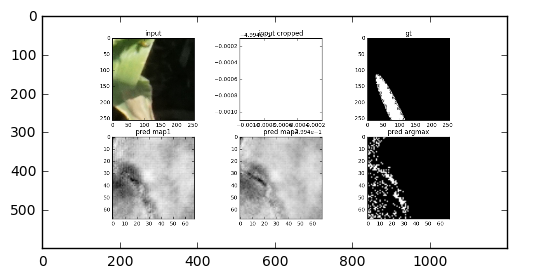

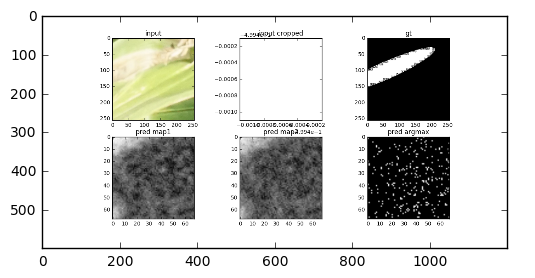

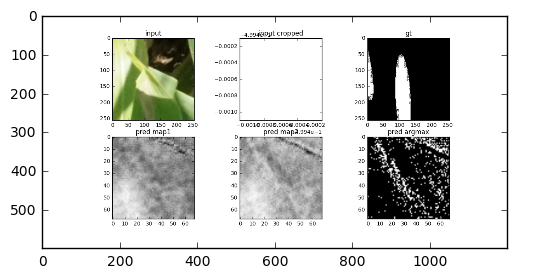

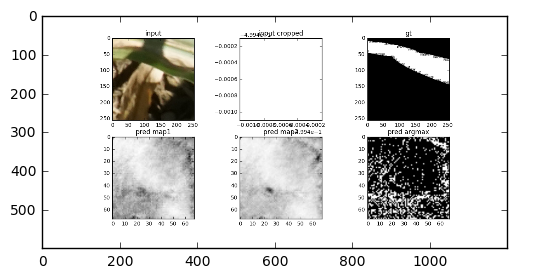

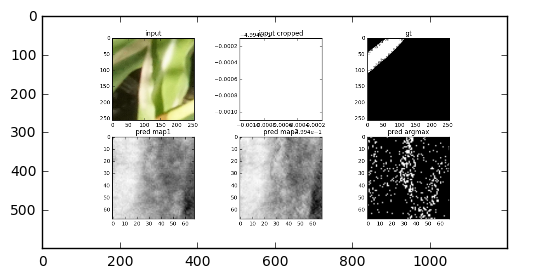

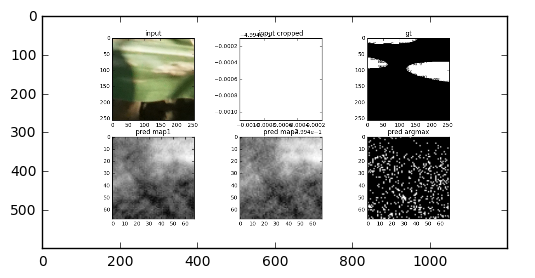

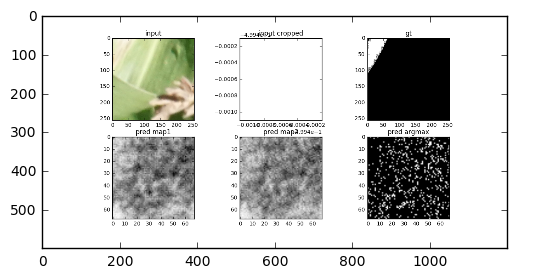

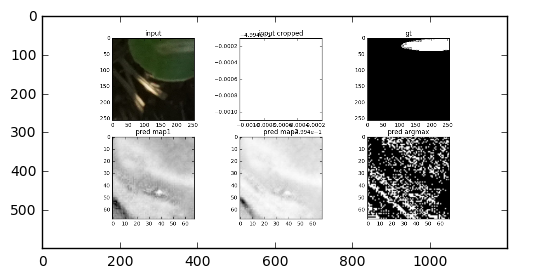

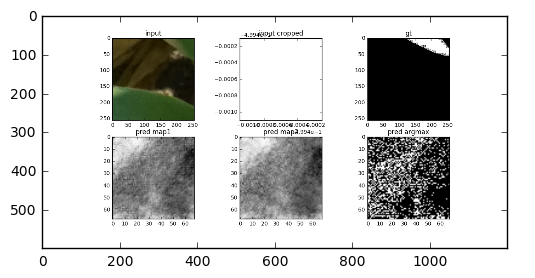

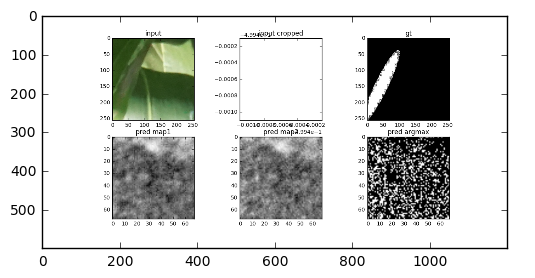

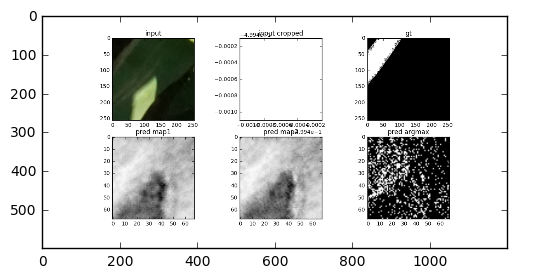

In [40]:
import os
files = [os.path.join(results_eval_path,f) for f in os.listdir(results_eval_path) if f.endswith('.png')][:30]
print files

for f in files:
    plt.figure()
    plt.imshow(plt.imread(f))

---
<a name='c'/>
# Conclusions
</a>